# Profiling Results Accuracy

This file compares the accuracy of the following profiling results:

* Baseline: exhaustive profiling (159 resource profiles, based on the complete AWS profiles range in 64 MB steps)
* Linear model (linear interpolation between an evenly distributed selection of 5% of the exhaustive profiling results)
* Bayesian Optimization

In [1]:
from dataclasses import dataclass
import pandas as pd
import yaml

# Definitions of our column names.
col_profile = 'profile'
col_exec_time = 'execTime'
col_cost = 'cost'

@dataclass
class FunctionProfilingResults:
    input_sizes: list[int]
    '''All input sizes for this function in ascending order.'''
    
    results: dict[int, pd.DataFrame]
    '''The results indexed by input size.'''


def extract_input_sizes(func_desc) -> list[int]:
    ret: list[int] = []
    typical_inputs = func_desc['spec']['functionDescription']['typicalInputs']
    for input in typical_inputs:
        ret.append(input['sizeBytes'])
    return ret

def add_result(profile_result, dest_results_per_input: dict[int, list[dict[str, object]]]):
    profile = profile_result['resourceProfileId']
    results = profile_result.get('results')
    if results is not None:
        for input_result in results:
            results_list = dest_results_per_input[input_result['inputSizeBytes']]
            results_list.append({ col_profile: profile, col_exec_time: input_result['executionTimeMs'], col_cost: float(input_result['executionCost'])})


def load_result(path: str) -> FunctionProfilingResults:
    '''
    Reads a FunctionDescription YAML file and returns a dictionary of the profiling results,
    indexed by input size.
    '''
    with open(path, 'r') as file:
        func_desc = yaml.safe_load(file)
    input_sizes = extract_input_sizes(func_desc)
    results_per_input = { 
        input_size: [] for input_size in input_sizes 
    }

    all_results = func_desc['status']['profilingResults']['results']
    for profile_result in all_results:
        add_result(profile_result, results_per_input)

    data_frames: dict[int, pd.DataFrame] = {}
    for input_size, results in results_per_input.items():
        df = pd.DataFrame(data=results, columns=[col_profile, col_exec_time, col_cost])
        df = df.set_index(col_profile)
        data_frames[input_size] = df
    return FunctionProfilingResults(input_sizes=input_sizes, results=data_frames)


def load_results(functions: list[str], profiling_type: str) -> dict[str, FunctionProfilingResults]:
    '''
    Loads the results for all specified functions. profiling_type may be 'aws', 'gcf', or 'bo'.
    '''
    ret: dict[str, dict[int, pd.DataFrame]] = {
        func: load_result(f'./profiling-results/{profiling_type}/{func}.yaml') for func in functions
    }
    return ret


In [2]:
all_functions = [
    # LogPro
    'validate-log',
    'extract-basic-stats',
    'extract-successes',
    'extract-success-stats',

    # VidPro
    'validate-video',   
    'cut-video',
    'merge-videos',

    # FaceDet
    'validate-video-face-recog',
    'transform-video',
    'detect-faces',
    'mark-faces',
]

aws_results = load_results(all_functions, 'aws')
bo_results = load_results(all_functions, 'bo')
exhaustive_results = aws_results

In [3]:
import matplotlib.pyplot as plt

def matplot_exhaustive_bo_comparison(exhaustive_result: pd.DataFrame, bo_result: pd.DataFrame):
    fig, ax = plt.subplots()
    exhaustive_result[[col_exec_time]].plot(ax=ax, label='Exhaustive')
    bo_result[[col_exec_time]].plot(ax=ax, label='BO')
    ax.legend()

In [4]:
import seaborn as sns

sns.set_theme()

def seaplot_exhaustive_bo_comparison(exhaustive_result: pd.DataFrame, bo_result: pd.DataFrame, title: str):
    exhaustive_result = exhaustive_result[[col_exec_time]].rename(columns={col_exec_time: 'Exhaustive'})
    bo_result = bo_result[[col_exec_time]].rename(columns={col_exec_time: 'BO'})
    joined = exhaustive_result.join(bo_result)
    melted = joined.reset_index().melt(id_vars=[col_profile], var_name='type', value_name=col_exec_time)
    g: sns.FacetGrid = sns.relplot(
        data=melted, kind="line",
        x=col_profile, y=col_exec_time, #col="align",
        hue="type", #size="coherence", style="choice",
        facet_kws=dict(sharex=True),
    )
    g.set_axis_labels('Profile', 'Execution Time (ms)')
    g.set_xticklabels(step=10, rotation=45)
    g.ax.set_title(title)

In [5]:
# mark_faces_bo = bo_results['mark-faces']
# largest_input_result_bo = mark_faces_bo.results[mark_faces_bo.input_sizes[-1]]
# mark_faces_aws = aws_results['mark-faces']
# largest_input_result_aws = mark_faces_aws.results[mark_faces_aws.input_sizes[-1]]

# seaplot_exhaustive_bo_comparison(largest_input_result_aws, largest_input_result_bo, 'mark-faces large')

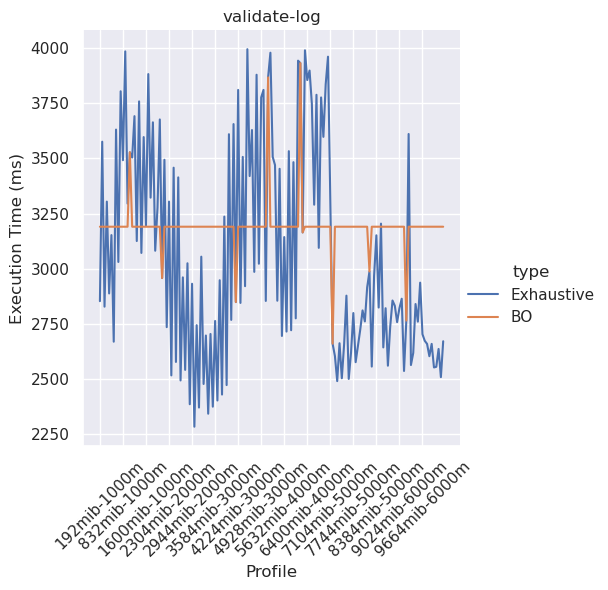

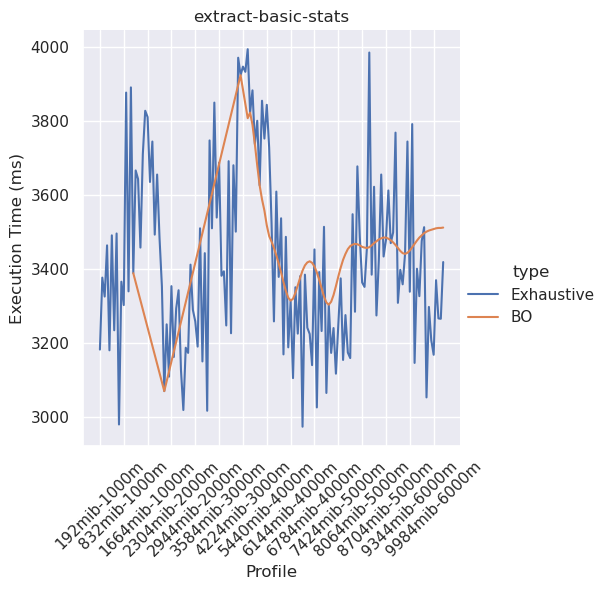

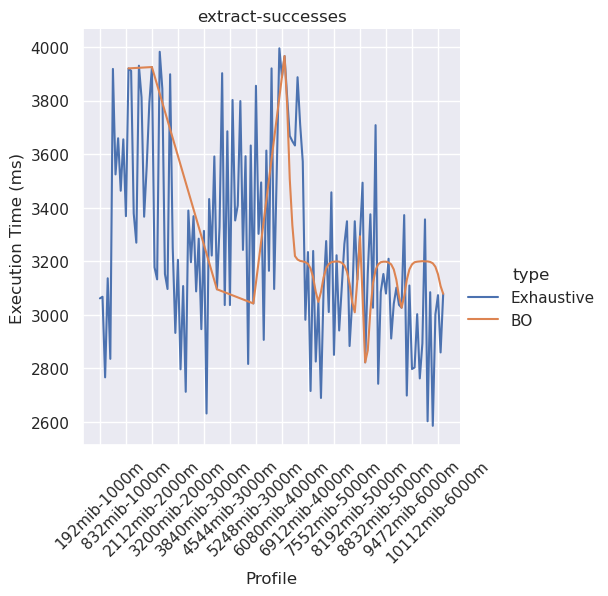

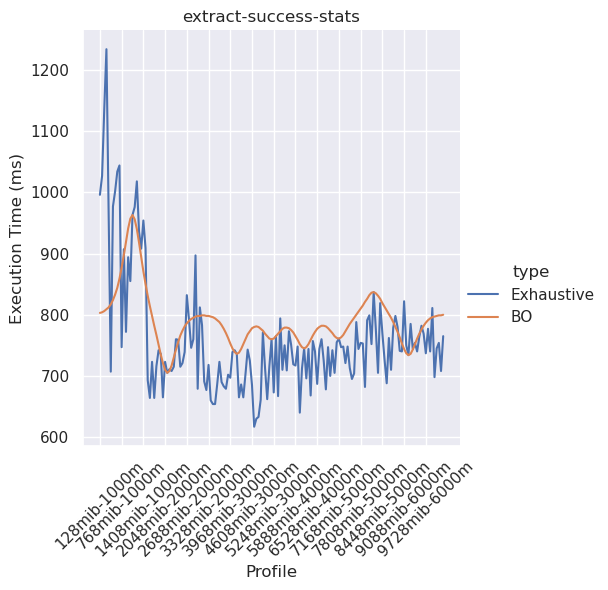

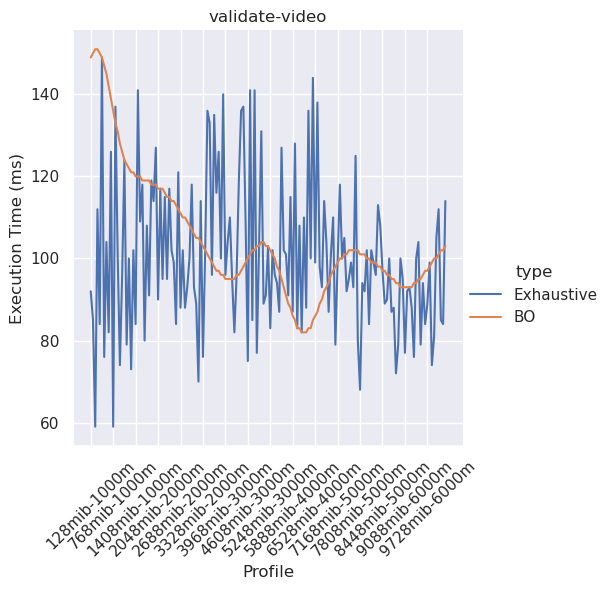

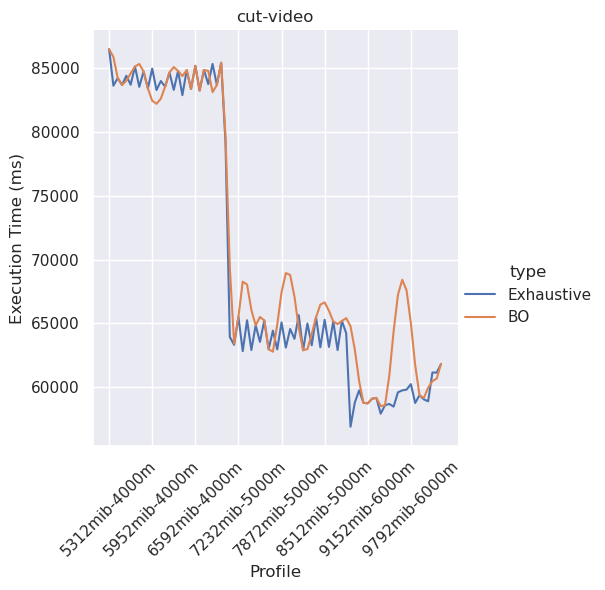

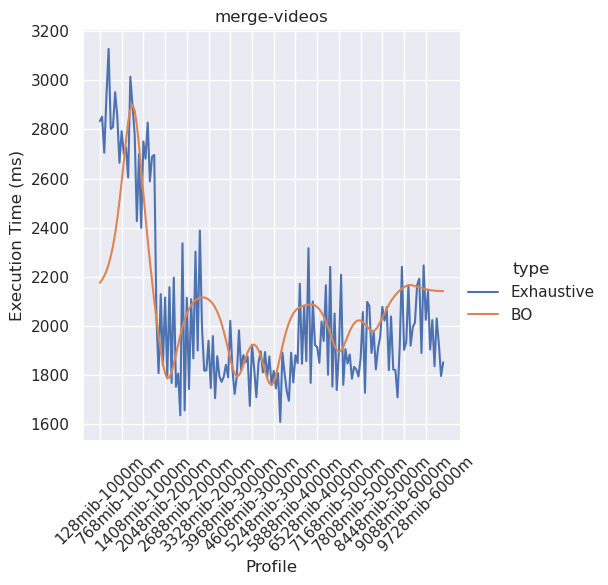

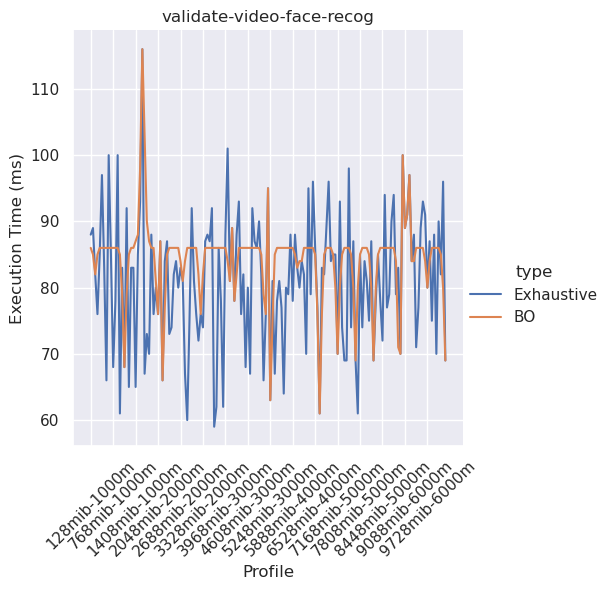

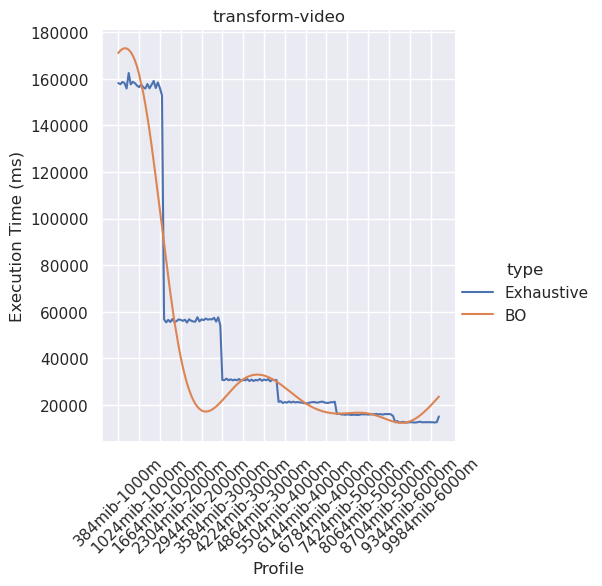

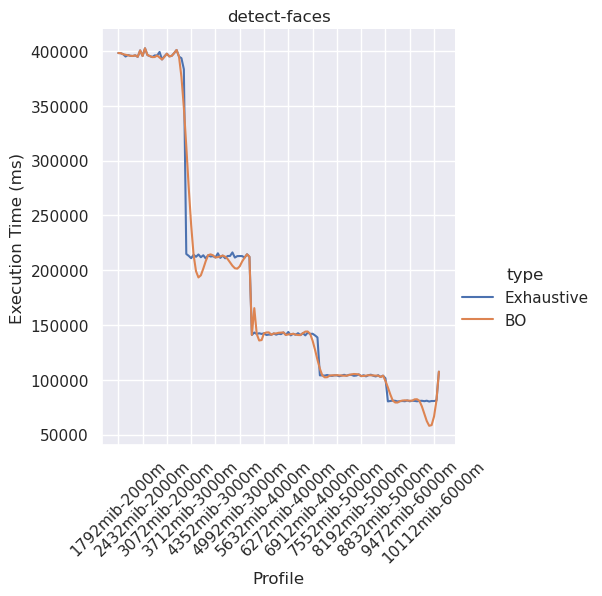

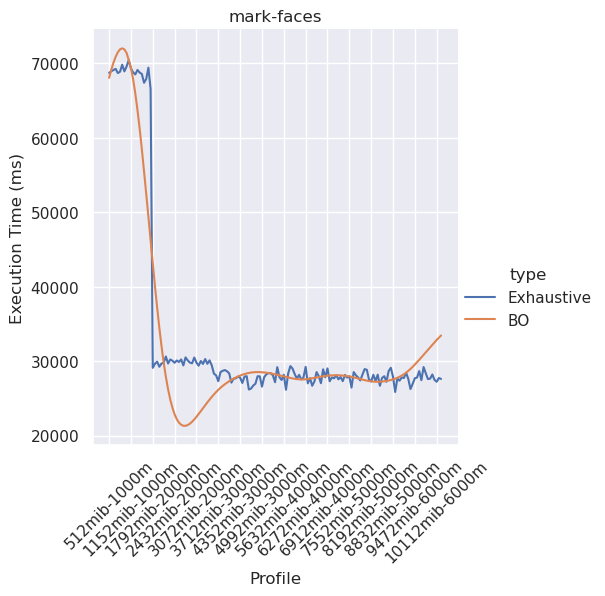

In [6]:
for key, exhaustive_result in exhaustive_results.items():
    bo_result = bo_results[key]
    exhaustive_largest_input_result = exhaustive_result.results[exhaustive_result.input_sizes[-1]]
    bo_largest_input_result = bo_result.results[bo_result.input_sizes[-1]]
    seaplot_exhaustive_bo_comparison(exhaustive_largest_input_result, bo_largest_input_result, key)